In [1]:
from pprint import pprint

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import CategoricalNB, ComplementNB
from sklearn.metrics import plot_roc_curve, roc_auc_score, plot_confusion_matrix, roc_curve, confusion_matrix, auc, accuracy_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold

from pipelines import nested_cross_validate_score, pipeline_Donker
from transform import combine_tsv_files
from utils import double_cross_validate, get_sub_pipeline

In [2]:
# Difference genomic variable.
X, y = combine_tsv_files(
    "output/all__gene__up_or_down__No. Mutant Molecules per mL.tsv",
    "output/all__gene__up_or_down__CNV Score.tsv",
)

y_resp = y['response_grouped'].map({
    'non responder (sd+pd)': 'non responder (sd+pd+ne)', 
    'non evaluable (ne)': 'non responder (sd+pd+ne)',
    'responder (pr+cr)': 'responder (pr+cr)',
})

In [3]:
from models import TransformColumnType

def genomics_discretiser(value):
    """ Bin genomics with ordinal encoding. """
    if value > 0:
        return ">0"
    elif value < 0:
        return "<0"
    return "0"

X_T = TransformColumnType(
    column_type="numeric", transformation=genomics_discretiser
).fit_transform(X)

In [4]:
columns_to_merge = []
for c in X_T.columns:
    item_counts = X_T[c].value_counts()
    if '<0' in item_counts.index or '>0' in item_counts.index:
        # Only if both items are present and both are bigger than 5, no longer a candidate.
        if '<0' in item_counts.index and '>0' in item_counts.index:
            if item_counts['<0'] > 5 or item_counts['>0'] > 5:
                continue
        columns_to_merge.append(c)
pprint(columns_to_merge)

['DDR2_snv',
 'GNAQ_snv',
 'PIK3R1_snv',
 'PTEN_snv',
 'TSC1_snv',
 'TSC2_snv',
 'NF2_snv',
 'PDCD1LG2_snv',
 'ABL1_snv',
 'CCND2_snv',
 'CDK4_snv',
 'CDK6_snv',
 'CSF1R_snv',
 'CTNNB1_snv',
 'ERBB2_snv',
 'ESR1_snv',
 'FGFR3_snv',
 'FLT3_snv',
 'MLH1_snv',
 'MSH6_snv',
 'NTRK1_snv',
 'RAF1_snv',
 'SMO_snv',
 'AKT1_snv',
 'AKT2_snv',
 'ARAF_snv',
 'GATA3_snv',
 'MAP2K1_snv',
 'MAP2K2_snv',
 'NRAS_snv',
 'IDH1_snv',
 'CD274_snv',
 'Age',
 'stage',
 'therapyline']


In [5]:
columns_to_merge = [
 'DDR2_snv',
 'GNAQ_snv',
 'PIK3R1_snv',
 'PTEN_snv',
 'TSC1_snv',
 'TSC2_snv',
 'NF2_snv',
 'PDCD1LG2_snv',
 'ABL1_snv',
 'CCND2_snv',
 'CDK4_snv',
 'CDK6_snv',
 'CSF1R_snv',
 'CTNNB1_snv',
 'ERBB2_snv',
 'ESR1_snv',
 'FGFR3_snv',
 'FLT3_snv',
 'MLH1_snv',
 'MSH6_snv',
 'NTRK1_snv',
 'RAF1_snv',
 'SMO_snv',
 'AKT1_snv',
 'AKT2_snv',
 'ARAF_snv',
 'GATA3_snv',
 'MAP2K1_snv',
 'MAP2K2_snv',
 'NRAS_snv',
 'IDH1_snv',
 'CD274_snv']

In [6]:
X_merged = X.drop(columns=columns_to_merge)
X_merged['OTHER_snv'] = X[columns_to_merge].sum(axis=1)

In [7]:
# p = pipeline_Donker(CategoricalNB())
p = pipeline_Donker(ComplementNB())

In [8]:
@double_cross_validate(5, 5)
def multi_class_metrics(clf, X, y):
    mean_fpr = np.linspace(0, 1, 100)
    metrics = {}
    # Make one v.s. rest classification.
    for class_name in ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']:
        ybin_true = y == class_name
        class_index = list(clf.classes_).index(class_name)
        y_prob = clf.predict_proba(X)[:, class_index]
        ybin_pred = clf.predict(X) == class_name
        fpr, tpr, _ = roc_curve(ybin_true, y_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        metrics.update({
            f'{class_name}__tprs': interp_tpr,
            f'{class_name}__fprs': mean_fpr,
            f'{class_name}__roc_auc': roc_auc_score(ybin_true, y_prob),
            f'{class_name}__accuracy': accuracy_score(ybin_true, ybin_pred),
            f'{class_name}__confusion_matrix': confusion_matrix(ybin_true, ybin_pred, normalize='true'),
        })
        print(class_name, roc_auc_score(ybin_true, y_prob))
    return metrics

In [29]:
from sklearn.metrics import precision_score

@double_cross_validate(5, 5)
def metrics_binary_class(clf, X, y, positive_class):
    negative_class = 'non responder (sd+pd+ne)'
    mean_fpr = np.linspace(0, 1, 100)
    metrics = {}
    class_index = list(clf.classes_).index(positive_class)
    y_prob = clf.predict_proba(X)[:, class_index]
    y_pred = clf.predict(X)
    fpr, tpr, _ = roc_curve(y, y_prob, pos_label=positive_class)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    
    assert positive_class != negative_class
    y_ol = np.full(shape=y.shape, fill_value=negative_class)
    operating_line = 0.05
    y_ol[y_prob > operating_line] = positive_class

    interp_tpr[0] = 0.0
    metrics.update(
        {
            f"{positive_class}__tprs": interp_tpr,
            f"{positive_class}__fprs": mean_fpr,
            f"{positive_class}__roc_auc": roc_auc_score(y, y_prob),
            f"{positive_class}__accuracy": accuracy_score(y, y_pred),
            f"{positive_class}__operator__confusion_matrix": confusion_matrix(y, y_ol, normalize='true'),
            f"{positive_class}__confusion_matrix": confusion_matrix(
                y, y_pred, normalize="true"
            ),
        }
    )
    print(positive_class, roc_auc_score(y, y_prob))
    return metrics

In [30]:
resp_mean, resp_std = metrics_binary_class(p, X_merged, y_resp, positive_class="responder (pr+cr)")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


responder (pr+cr) 0.8247863247863247
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


responder (pr+cr) 0.5982905982905983
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


responder (pr+cr) 0.6239316239316239
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


responder (pr+cr) 0.7051282051282051
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


responder (pr+cr) 0.7511111111111111


# Predicting responder vs non-evaluable and non-responders

Accuracy: 0.6211764705882353


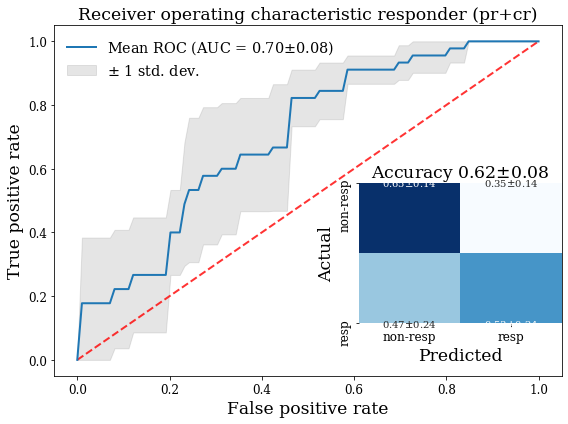

In [31]:
from views import plot_roc_curve
plt.rc("font", family="serif")
plt.figure(figsize=(8, 6))
plot_roc_curve(resp_mean, resp_std, class_name='responder (pr+cr)', labels=['non-resp', 'resp'])
plt.tight_layout()
plt.savefig('response_prediction.png')

In [32]:
print(y_resp.value_counts())
resp_mean['responder (pr+cr)__operator__confusion_matrix']

non responder (sd+pd+ne)    129
responder (pr+cr)            45
Name: response_grouped, dtype: int64


array([[0.19446154, 0.80553846],
       [0.04444444, 0.95555556]])

## Predicting overall survival

In [13]:
y_OS = y['OS_months'].apply(lambda x: '<1yr' if x < 12.0 else r'>=1yr')
# Verify that none of <1yr group is censored.
assert np.all(y[y['OS_months'] < 12.0]['Censor_OS'] == 1.0)

y_PFS = y['PFS_months'].apply(lambda x: '<1yr' if x < 12.0 else r'>=1yr')
# Verify that none of <1yr group is censored.
assert np.all(y[y['PFS_months'] < 12.0]['Censor_progression'] == 'progression of disease')

In [14]:
OS_mean, OS_std = metrics_binary_class(p, X_merged, y_OS, positive_class='>=1yr')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
PFS_mean, PFS_std = metrics_binary_class(p, X_merged, y_PFS, positive_class='>=1yr')

In [ ]:
plot_roc_curve(OS_mean, OS_std, class_name='>=1yr', labels=['<1yr', '>=1yr'])
plt.savefig('os_prediction.png')

## Predicting progression free survival

In [ ]:
plot_roc_curve(PFS_mean, PFS_std, class_name='>=1yr', labels=['<1yr', '>=1yr'])
plt.savefig('pfs_prediction.png')

# Predicting responders, non-responders _and_ non-evaluable.

In [ ]:
p.fit(X, y['response_grouped'])
m_mean, m_std = multi_class_metrics(p, X, y['response_grouped'])
for class_name in ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']:
    plot_roc_curve(m_mean, m_std, class_name)